In [ ]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import itertools

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.metrics import geometric_mean_score

## [Comparison of ensembling classifiers internally using sampling](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py)

Ensembling classifiers have shown to improve classification performance compare to single learner. However, they will be affected by class imbalance. This example shows the benefit of balancing the training set before to learn learners. We are making the comparison with non-balanced ensemble methods.

We make a comparison using the balanced accuracy and geometric mean which are metrics widely used in the literature to evaluate models learned on imbalanced set.

In [1]:
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

## Load an imbalanced dataset

We will load the UCI SatImage dataset which has an imbalanced ratio of 9.3:1 (number of majority sample for a minority sample). The data are then split into training and testing.

In [2]:
satimage = fetch_datasets()['satimage']
X, y = satimage.data, satimage.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=0)

## Classification using a single decision tree

We train a decision tree classifier which will be used as a baseline for the rest of this example.
The results are reported in terms of balanced accuracy and geometric mean which are metrics widely used in the literature to validate model trained on imbalanced set.

Decision tree classifier performance:
Balanced accuracy: 0.74 - Geometric mean 0.71
[[1385   67]
 [  75   82]]



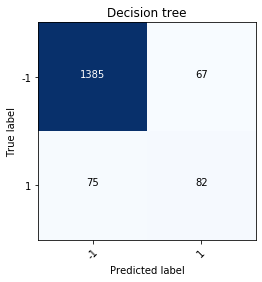

In [3]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_tree),
              geometric_mean_score(y_test, y_pred_tree)))
cm_tree = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(satimage.target), ax=ax,
                      title='Decision tree')

## Classification using bagging classifier with and without sampling

Instead of using a single tree, we will check if an ensemble of decsion tree can actually alleviate the issue induced by the class imbalancing. First, we will use a bagging classifier and its counter part which internally uses a random under-sampling to balanced each boostrap sample.

Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.

In [4]:
bagging = BaggingClassifier(n_estimators=50, random_state=0, n_jobs=-1)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0,
                                             n_jobs=-1)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Bagging classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.69
[[1428   24]
 [  81   76]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.87 - Geometric mean 0.87
[[1326  126]
 [  28  129]]



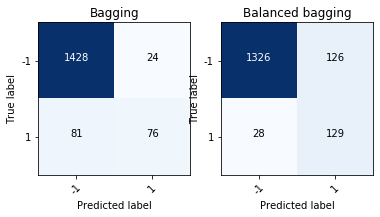

In [5]:
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(satimage.target), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(satimage.target),
                      ax=ax[1], title='Balanced bagging')

## Classification using random forest classifier with and without sampling

Random forest is another popular ensemble method and it is usually outperforming bagging. Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

Random Forest classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.68
[[1435   17]
 [  84   73]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.87 - Geometric mean 0.87
[[1275  177]
 [  21  136]]



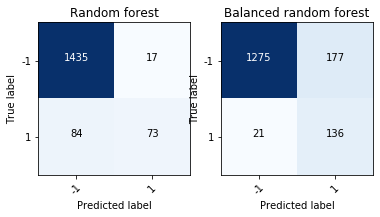

In [8]:
rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0,
                                     n_jobs=-1)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_rf, classes=np.unique(satimage.target), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(satimage.target), ax=ax[1],
                      title='Balanced random forest')